## Reduced Rank Regression

In [2]:
import os
import pickle as pkl
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from utils.helpers import *

# autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
# Load the data
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
data = load_data(data_path, 'ssp585_time_series.pkl')

In [4]:
filtered_data = filter_data(data)

In [5]:
# Create a NaN mask
nan_mask = create_nan_mask(filtered_data)

# Apply the NaN mask
masked_data = remove_nans(filtered_data, nan_mask)

100%|██████████| 34/34 [00:03<00:00, 11.06it/s]


In [6]:
reshaped_data = reshape_data(masked_data)

100%|██████████| 34/34 [01:31<00:00,  2.69s/it]


In [7]:
example_model = 'CanESM5-1'
example_model_data = reshaped_data[example_model]
print(f"Randomly selected model: {example_model}, which has {len(example_model_data)} runs.")

Randomly selected model: CanESM5-1, which has 72 runs.


In [8]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x (Latitude x Longitude))

(165, 10368)

In [ ]:
# Keep only the first 2 models as an example
example_models = list(reshaped_data.keys())[:2]
example_models_data = {model: reshaped_data[model] for model in example_models}

In [24]:
# Now Normalizing the reshaped data
normalized_data, scaler = normalize_data(example_models_data)

c:\ProgramData\anaconda3\envs\Project\lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\ProgramData\anaconda3\envs\Project\lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\ProgramData\anaconda3\envs\Project\lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


In [25]:
# Shape of the 1st run of the 1st model
normalized_data[example_models[0]][list(normalized_data[example_models[0]].keys())[0]].shape # Shape (Time x (Latitude x Longitude))

(165, 10368)

In [26]:
data_forced_responses = add_forced_response(normalized_data)

In [29]:
data_forced_responses['ICON-ESM-LR'].keys()

dict_keys(['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'forced_response'])

In [31]:
forced_response_1 = data_forced_responses['ICON-ESM-LR']['forced_response']
print(f"Shape of the forced response: {forced_response_1.shape}")

Shape of the forced response: (165, 10368)


In [32]:
data_for_plotting = forced_response_1.reshape(-1, 72, 144)

In [ ]:
data_for_plotting.shape # Back to the original shape

(165, 72, 144)

## Plot the data of a random grid cell to be sure that the transformations were applied correctly

Displaying the forced response and runs for grid spot: [31 95]


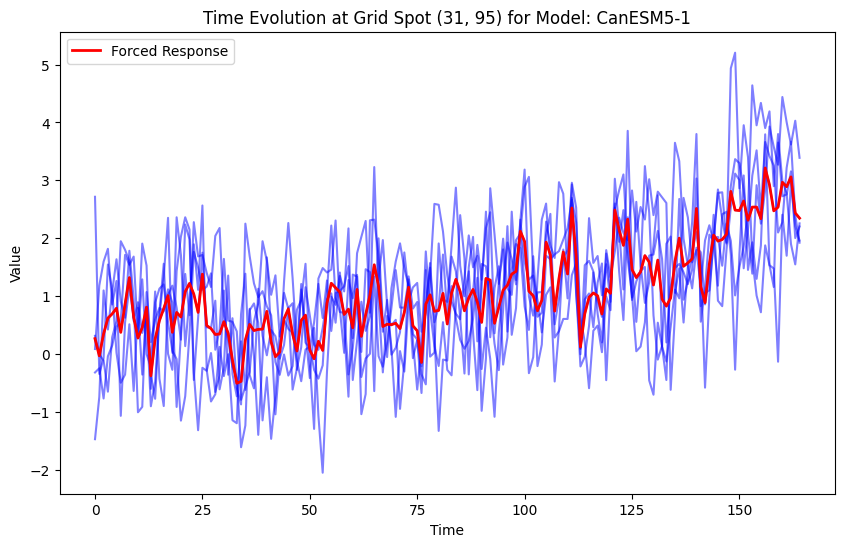

In [37]:
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run
time_series_data = {run : data_forced_responses['ICON-ESM-LR'][run].reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]] for run in data_forced_responses['ICON-ESM-LR']}
forced_response_data = data_forced_responses['ICON-ESM-LR']['forced_response'].reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs and the forced response
plt.figure(figsize=(10, 6))
for data in time_series_data.values():
    plt.plot(data, color='blue', alpha=0.5)
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {example_model}')
plt.xlabel('Time') # Need to change this
plt.ylabel('Value')
# plt.ylim(-2,4)
plt.legend()
plt.show()

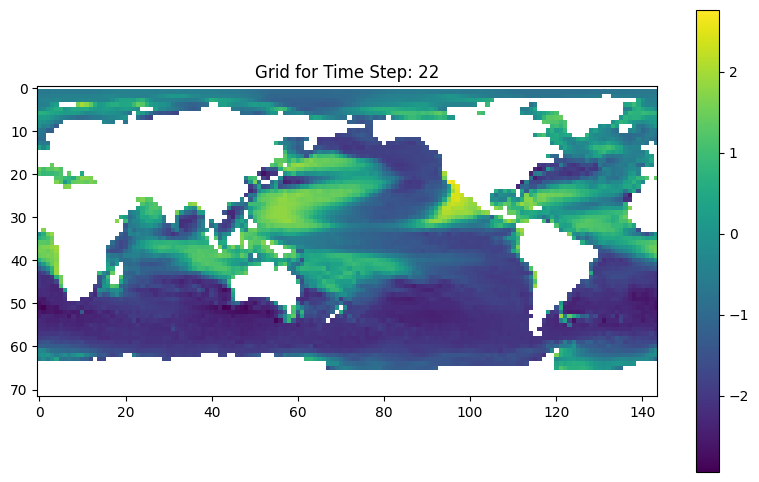

In [40]:
# Plot the grid for a random time step
time_step = random.randint(0, 165)
plt.figure(figsize=(10, 6))
plt.imshow(data_for_plotting[time_step], cmap='viridis')
plt.colorbar()
plt.title(f'Grid for Time Step: {time_step}')
plt.show()

## The data is now normalized with the forced response being calculated (on the normalized data)

In [13]:
X_all, y_all = pool_data(data_forced_responses)

In [14]:
X_all.shape, y_all.shape

((4950, 10368), (4950, 10368))

In [16]:
# Perform the Reduced Rank Regression
B_rrr = reduced_rank_regression(X_all, y_all, rank=2)

MemoryError: Unable to allocate 820. MiB for an array with shape (10368, 10368) and data type float64